# ==================================================

# Task 3

In [1]:
### import os
import wer
import openfst_python as fst
import glob
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
from vetrbi import MyViterbiDecoder
from utils import parse_lexicon, generate_symbol_tables
from hmm import generate_word_sequence_recognition_wfst
from hmm import generate_word_sequence_recognition_wfst_with_silance
from utils import draw
import numpy as np
import pickle

def create_wfst():
    f = generate_word_sequence_recognition_wfst(3)
    f.set_input_symbols(state_table)
    f.set_output_symbols(phone_table)
    return f

def create_wfst_with_silance():
    f = generate_word_sequence_recognition_wfst_with_silance(3, use_unigram_probs=False)
    f.set_input_symbols(state_table)
    f.set_output_symbols(phone_table)
    return f

def create_lexical():
    f = generate_lexical_hmm(1, use_unigram_probs=False)
    f.set_input_symbols(state_table)
    f.set_output_symbols(phone_table)
    return f

def read_transcription(wav_file):
    """
    Get the transcription corresponding to wav_file.
    """
    
    transcription_file = os.path.splitext(wav_file)[0] + '.txt'
    
    with open(transcription_file, 'r') as f:
        transcription = f.readline().strip()
    
    return transcription

def memory_of_wfst(f):
    '''
    Compute a measure of the memory required for your decoder by providing counts
    of number of states and arcs in the WFST.
    '''
    all_states = []
    all_arcs = []
    for state in f.states():
        all_states.append(state)
        for arc in f.arcs(state):
            all_arcs.append(arc)
    return len(all_states), len(all_arcs)
    
def get_avg_wer(all_losses, verbose=False):
    all_wer = []
    for error_counts, word_count in all_losses:
        all_wer.append(sum(error_counts) / word_count)
    
    if verbose :
        print(f'The average WER is {np.mean(all_wer):.2%}')    
    return np.mean(all_wer)

def get_avg_effciency(efficancy_measures, verbose=False):
    decoding_time = np.mean(efficancy_measures[0])
    backtrace_time = np.mean(efficancy_measures[1])
    number_of_computions = np.mean(efficancy_measures[2])
    if verbose:
        print(f'The average decoding time is {decoding_time:.2f} seconds')
        print(f'The average backtrace time is {backtrace_time:.2f} seconds')
        print(f'The average number of computations is {number_of_computions:.2f}')
    return decoding_time, backtrace_time, number_of_computions


def decoding_loop(f, train_set=True, train_split=0.85, use_pruning=False, determinized=False, verbose=False, prune_threshold= None, histogram_pruning_threshold = 0):
    all_losses = []
    decoding_time = []
    backtrace_time = []
    number_of_computations = []
    all_files = glob.glob('/group/teaching/asr/labs/recordings/*.wav')
    train_files = all_files[:(int(train_split*len(all_files)))]
    test_files = all_files[(int(train_split*len(all_files))):]
    
    if train_set:
        files= train_files
    else:
        files = test_files
    
    for wav_file in tqdm(files):    
        decoder  = MyViterbiDecoder(f, wav_file, verbose=verbose, use_pruning=use_pruning, determinized=determinized, histogram_pruning_threshold=histogram_pruning_threshold)
        if use_pruning and prune_threshold!=None:
            decoder.prune_threshold = prune_threshold
        decoder.decode()
        (state_path, words) = decoder.backtrace()  
        transcription = read_transcription(wav_file)
        error_counts = wer.compute_alignment_errors(transcription, words)
        word_count = len(transcription.split())

        all_losses.append((error_counts, word_count))
        decoding_time.append(decoder.decode_time)
        backtrace_time.append(decoder.backtrace_time)
        number_of_computations.append(decoder.number_of_computiations)
        if verbose:
            print(f'Transcription: {transcription} || Prediction: {words} || (nsub, ndel, nin) :{error_counts}')
    
    efficancy_measures = (decoding_time, backtrace_time, number_of_computations)
    return all_losses, efficancy_measures


lex = parse_lexicon('lexicon.txt')
word_table, phone_table, state_table = generate_symbol_tables(lex)
f = create_wfst()
f_silence = create_wfst_with_silance()

 85%|████████████████████████████████▏     | 269/318 [00:00<00:00, 15795.43it/s]


In [ ]:
exp_dict= {
    'loss' : [],
    'efficancy':[],
    'acc': [],
    'm1': [],
    'm2': [],
    'm3': []
    
}
prune_thresholds = [i*10 for i in range(1,21)]
verbose = False
for prune_threshold in prune_thresholds:
    print(f'Threshold = {prune_threshold}')
    all_losses, efficancy_measures = decoding_loop(f, train_set=True, train_split=0.5, use_pruning=True, histogram_pruning_threshold=prune_threshold, verbose=verbose)
    
    avg_wer = get_avg_wer(all_losses, verbose=True)
    m1,m2,m3 = get_avg_effciency(efficancy_measures, verbose=verbose)
    exp_dict['loss'].append(all_losses)
    exp_dict['efficancy'].append(efficancy_measures)
    exp_dict['acc'].append(avg_wer)
    exp_dict['m1'].append(m1)
    exp_dict['m2'].append(m2)
    exp_dict['m3'].append(m3)
    print('\n\n\n')
    file_name = f'exp_dict_baseline_histogram_{prune_threshold}.pkl'
    with open(file_name, 'wb') as handler:
        pickle.dump(exp_dict, handler)
    print(f'saved to {file_name}')





Threshold = 10


100%|█████████████████████████████████████████| 159/159 [03:36<00:00,  1.36s/it]


The average WER is 100.84%




saved to exp_dict_baseline_histogram_10.pkl
Threshold = 20


100%|█████████████████████████████████████████| 159/159 [05:07<00:00,  1.94s/it]


The average WER is 235.69%




saved to exp_dict_baseline_histogram_20.pkl
Threshold = 30


100%|█████████████████████████████████████████| 159/159 [06:01<00:00,  2.27s/it]


The average WER is 134.03%




saved to exp_dict_baseline_histogram_30.pkl
Threshold = 40


100%|█████████████████████████████████████████| 159/159 [06:40<00:00,  2.52s/it]


The average WER is 173.89%




saved to exp_dict_baseline_histogram_40.pkl
Threshold = 50


 10%|████▏                                     | 16/159 [00:36<05:08,  2.16s/it]

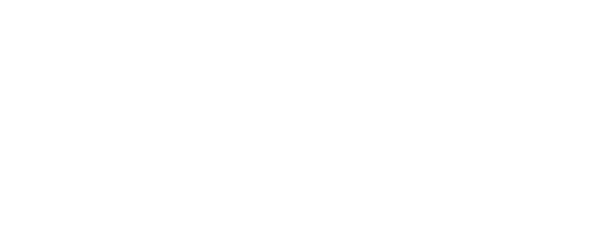

In [3]:
f

In [3]:
exp_dict= {
    'loss' : [],
    'efficancy':[],
    'acc': [],
    'm1': [],
    'm2': [],
    'm3': []
    
}
prune_thresholds  = [5,10,15,20,25,30,45,50,55,60,65, 70,75,80,85,90,95,100,110,120,130,140,150,160,170,180,190,200,250,300]
verbose = False
for prune_threshold in prune_thresholds:
    print(f'Threshold = {prune_threshold}')
    all_losses, efficancy_measures = decoding_loop(f, train_set=True, train_split=0.03, use_pruning=True, histogram_pruning_threshold=prune_threshold, verbose=verbose)
    avg_wer = get_avg_wer(all_losses, verbose=True)
    m1,m2,m3 = get_avg_effciency(efficancy_measures, verbose=verbose)
    exp_dict['loss'].append(all_losses)
    exp_dict['efficancy'].append(efficancy_measures)
    exp_dict['acc'].append(avg_wer)
    exp_dict['m1'].append(m1)
    exp_dict['m2'].append(m2)
    exp_dict['m3'].append(m3)
    print('\n\n\n')




Threshold = 5


 11%|█████                                        | 1/9 [00:00<00:06,  1.14it/s]

No path got to the end of the observations.


 22%|██████████                                   | 2/9 [00:01<00:05,  1.37it/s]

No path got to the end of the observations.


 33%|███████████████                              | 3/9 [00:02<00:04,  1.37it/s]

No path got to the end of the observations.


 44%|████████████████████                         | 4/9 [00:02<00:03,  1.35it/s]

No path got to the end of the observations.


 56%|█████████████████████████                    | 5/9 [00:03<00:03,  1.28it/s]

No path got to the end of the observations.


 67%|██████████████████████████████               | 6/9 [00:05<00:03,  1.07s/it]

No path got to the end of the observations.


 78%|███████████████████████████████████          | 7/9 [00:06<00:02,  1.04s/it]

No path got to the end of the observations.


 89%|████████████████████████████████████████     | 8/9 [00:07<00:01,  1.08s/it]

No path got to the end of the observations.


100%|█████████████████████████████████████████████| 9/9 [00:08<00:00,  1.03it/s]


No path got to the end of the observations.
The average WER is 100.00%




Threshold = 10


 44%|████████████████████                         | 4/9 [00:04<00:05,  1.01s/it]

No path got to the end of the observations.


 56%|█████████████████████████                    | 5/9 [00:05<00:04,  1.07s/it]

No path got to the end of the observations.


 67%|██████████████████████████████               | 6/9 [00:07<00:04,  1.43s/it]

No path got to the end of the observations.


100%|█████████████████████████████████████████████| 9/9 [00:11<00:00,  1.27s/it]


No path got to the end of the observations.
The average WER is 119.32%




Threshold = 15


 11%|█████                                        | 1/9 [00:01<00:09,  1.25s/it]

No path got to the end of the observations.


 44%|████████████████████                         | 4/9 [00:04<00:05,  1.08s/it]

No path got to the end of the observations.


100%|█████████████████████████████████████████████| 9/9 [00:12<00:00,  1.42s/it]


The average WER is 156.59%




Threshold = 20


 56%|█████████████████████████                    | 5/9 [00:06<00:04,  1.23s/it]

No path got to the end of the observations.


100%|█████████████████████████████████████████████| 9/9 [00:13<00:00,  1.55s/it]


The average WER is 166.94%




Threshold = 25


100%|█████████████████████████████████████████████| 9/9 [00:14<00:00,  1.66s/it]


The average WER is 131.04%




Threshold = 30


100%|█████████████████████████████████████████████| 9/9 [00:15<00:00,  1.72s/it]


The average WER is 118.78%




Threshold = 45


100%|█████████████████████████████████████████████| 9/9 [00:18<00:00,  2.05s/it]


The average WER is 87.41%




Threshold = 50


100%|█████████████████████████████████████████████| 9/9 [00:18<00:00,  2.10s/it]


The average WER is 89.20%




Threshold = 55


100%|█████████████████████████████████████████████| 9/9 [00:19<00:00,  2.21s/it]


The average WER is 89.20%




Threshold = 60


100%|█████████████████████████████████████████████| 9/9 [00:21<00:00,  2.35s/it]


The average WER is 80.82%




Threshold = 65


100%|█████████████████████████████████████████████| 9/9 [00:22<00:00,  2.45s/it]


The average WER is 89.99%




Threshold = 70


100%|█████████████████████████████████████████████| 9/9 [00:24<00:00,  2.73s/it]


The average WER is 91.38%




Threshold = 75


100%|█████████████████████████████████████████████| 9/9 [00:24<00:00,  2.69s/it]


The average WER is 91.38%




Threshold = 80


100%|█████████████████████████████████████████████| 9/9 [00:25<00:00,  2.79s/it]


The average WER is 77.85%




Threshold = 85


100%|█████████████████████████████████████████████| 9/9 [00:26<00:00,  2.99s/it]


The average WER is 89.68%




Threshold = 90


100%|█████████████████████████████████████████████| 9/9 [00:32<00:00,  3.62s/it]


The average WER is 83.71%




Threshold = 95


100%|█████████████████████████████████████████████| 9/9 [00:28<00:00,  3.16s/it]


The average WER is 82.32%




Threshold = 100


100%|█████████████████████████████████████████████| 9/9 [00:29<00:00,  3.23s/it]


The average WER is 86.03%




Threshold = 110


100%|█████████████████████████████████████████████| 9/9 [00:31<00:00,  3.49s/it]


The average WER is 79.44%




Threshold = 120


100%|█████████████████████████████████████████████| 9/9 [00:31<00:00,  3.50s/it]


The average WER is 69.98%




Threshold = 130


100%|█████████████████████████████████████████████| 9/9 [00:31<00:00,  3.45s/it]


The average WER is 69.98%




Threshold = 140


100%|█████████████████████████████████████████████| 9/9 [00:30<00:00,  3.42s/it]


The average WER is 69.98%




Threshold = 150


100%|█████████████████████████████████████████████| 9/9 [00:30<00:00,  3.41s/it]


The average WER is 69.98%




Threshold = 160


100%|█████████████████████████████████████████████| 9/9 [00:31<00:00,  3.52s/it]


The average WER is 69.98%




Threshold = 170


100%|█████████████████████████████████████████████| 9/9 [00:33<00:00,  3.76s/it]


The average WER is 69.98%




Threshold = 180


100%|█████████████████████████████████████████████| 9/9 [00:30<00:00,  3.41s/it]


The average WER is 69.98%




Threshold = 190


100%|█████████████████████████████████████████████| 9/9 [00:30<00:00,  3.41s/it]


The average WER is 69.98%




Threshold = 200


100%|█████████████████████████████████████████████| 9/9 [00:30<00:00,  3.41s/it]


The average WER is 69.98%




Threshold = 250


100%|█████████████████████████████████████████████| 9/9 [00:30<00:00,  3.41s/it]


The average WER is 69.98%




Threshold = 300


100%|█████████████████████████████████████████████| 9/9 [00:32<00:00,  3.63s/it]

The average WER is 69.98%






In [ ]:
plt.plot(prune_thresholds, exp_dict['acc'])

In [ ]:
plt.plot(prune_thresholds, exp_dict['acc'])

# ======================================================